In [3]:
import os
import time
import cv2
import torch
import numpy as np
import math 
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
import seaborn as sns 
import torchvision.models as models

# os.chdir('..')
print(os.getcwd())

device = torch.device("cpu")

/home/tommaselli/Documents/IC_NN_Lidar


In [4]:
# open image with cv2 from folder: data/gazebo_data/train1/image0.png
#image = cv2.imread(os.path.join("data", "artificial_data", "train3", "image100.png"))
image = cv2.imread(os.path.join("data", "gazebo_data", "train3", "image50.png"))

# convert image to numpy 
image = np.array(image)

# crop image to 224x224 in the pivot point (112 to each side)
# image = image[100:400, :, :]
image = image[:,:, 1]
image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_LINEAR)

print(image.shape)

(224, 224)


width: 145 height: 51
[[ 1.69411765e+00  5.03529412e-01 -7.51176471e+01]
 [ 1.04711561e-15  2.64705882e+00 -1.41176471e+02]
 [ 7.08409666e-18  4.70588235e-03  1.00000000e+00]]


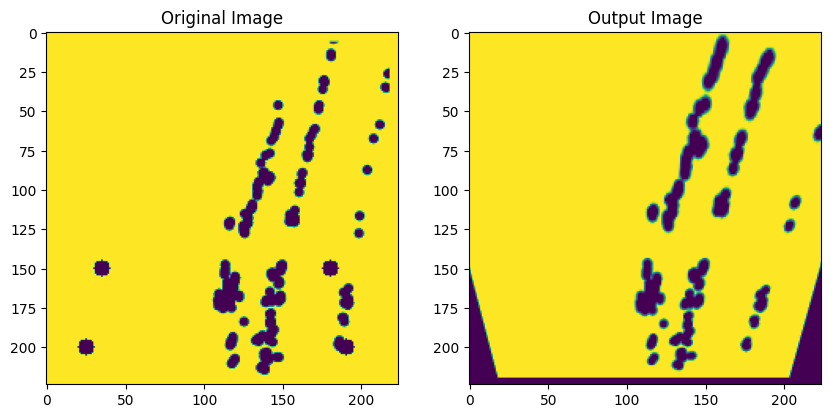

(224, 224)


In [5]:
hh, ww = image.shape[:2]

# specify input coordinates for corners of red quadrilateral in order TL, TR, BR, BL as x,
input = np.float32([[35,150], [180,150], [190,200], [25,200]])

# get top and left dimensions and set to output dimensions of red rectangle
width = round(math.hypot(input[0,0]-input[1,0], input[0,1]-input[1,1]))
height = round(math.hypot(input[0,0]-input[3,0], input[0,1]-input[3,1]))
print("width:",width, "height:",height)

# set upper left coordinates for output rectangle
x = input[0,0]
y = input[0,1]

# specify output coordinates for corners of red quadrilateral in order TL, TR, BR, BL as x,
output = np.float32([[x,y], [x+width-1,y], [x+width-1,y+height-1], [x,y+height-1]])

# compute perspective matrix
matrix = cv2.getPerspectiveTransform(input,output)
print(matrix)

# do perspective transformation setting area outside input to black
# Note that output size is the same as the input image size
imgOutput = cv2.warpPerspective(image, matrix, (ww,hh), cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0))

# Plot original image
# Draw input points on the image
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for point in input:
    x, y = map(int, point)  # Convert each element in the point to integers
    cv2.circle(image, (x, y), 5, (0, 255, 0), -1)

axs[0].imshow(image)
axs[0].set_title('Original Image')
axs[0].axis('on')

# Plot output image
axs[1].imshow(imgOutput)
axs[1].set_title('Output Image')
axs[1].axis('on')

plt.show()

print(image.shape)

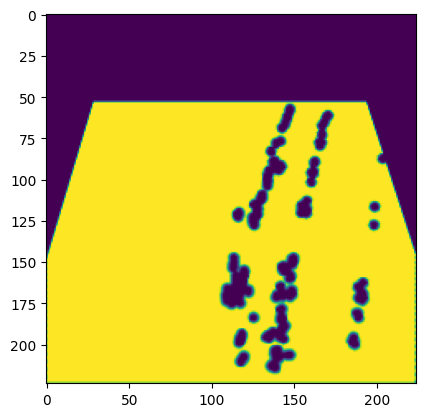

In [6]:
# invert matrix
matrix_inv = np.linalg.inv(matrix)

img = cv2.warpPerspective(imgOutput, matrix_inv, (ww,hh), cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0))

# Plot image
plt.imshow(img)
plt.show()

In [7]:
#image = imgOutput

In [8]:
########### MOBILE NET ########### 
model = models.mobilenet_v2(pretrained=True)
model.features[0][0] = torch.nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)

# MobileNetV2 uses a different attribute for the classifier
num_ftrs = model.classifier[1].in_features
model.classifier[1] = torch.nn.Sequential(
torch.nn.Linear(num_ftrs, 512),
torch.nn.BatchNorm1d(512),
torch.nn.ReLU(inplace=True),
torch.nn.Linear(512, 256),
torch.nn.BatchNorm1d(256),
torch.nn.ReLU(inplace=True),
torch.nn.Linear(256, 3)
)

path = os.getcwd() + '/models/' + 'model_005_17-01-2024_15-38-12.pth'
checkpoint = torch.load(path, map_location='cpu')  # Load to CPU
model.load_state_dict(checkpoint)
model.eval()

/home/tommaselli/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tommaselli/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [9]:
# add one more layer to image: [1, 1, 224, 224] as batch size
image = np.expand_dims(image, axis=0)
image = np.expand_dims(image, axis=0)

# convert to torch
image = torch.from_numpy(image).float()
print(image.shape)

torch.Size([1, 1, 224, 224])


In [10]:
# Inicie a contagem de tempo antes da inferência
start_time = time.time()

# get the model predictions
predictions = model(image)

# Encerre a contagem de tempo após a inferência
end_time = time.time()

print('Inference time: {:.4f} ms'.format((end_time - start_time)*1000))

Inference time: 71.5449 ms


In [11]:
def deprocess(image, label):
    ''' Returns the deprocessed image and label. '''

    if len(label) == 3:
        # we suppose m1 = m2, so we can use the same deprocess
        print('supposing m1 = m2')   
        w1, q1, q2 = label
        w2 = w1
    elif len(label) == 4:
        print('not supposing m1 = m2')        
        w1, w2, q1, q2 = label

    # DEPROCESS THE LABEL
    q1_original = ((q1 + 1) * (187.15 - (-56.06)) / 2) + (-56.06)
    q2_original = ((q2 + 1) * (299.99 - 36.81) / 2) + 36.81
    w1_original = ((w1 + 1) * (0.58 - (-0.58)) / 2) + (-0.58)
    w2_original = ((w2 + 1) * (0.58 - (-0.58)) / 2) + (-0.58)

    print(f'labels w1={w1}, w2={w2}, q1={q1}, q2={q2}')
    m1 = 1/w1_original
    m2 = 1/w2_original
    b1 = -q1_original / w1_original
    b2 = -q2_original / w2_original

    label = [m1, m2, b1, b2]

    return label

In [12]:
# convert the predictions to numpy array
predictions = predictions.to('cpu').cpu().detach().numpy()
predictions = deprocess(image=image, label=predictions[0].tolist())


# convert image to cpu 
image = image.to('cpu').cpu().detach().numpy()
# image it is shape (1, 1, 507, 507), we need to remove the first dimension
image = image[0][0]

supposing m1 = m2
labels w1=-0.7874817848205566, w2=-0.7874817848205566, q1=0.9531934261322021, q2=1.0083320140838623


In [13]:
# line equations explicitly

# get the x coordinates
x = np.arange(0, 224)

# get the slopes and intercepts
m1p, m2p, b1p, b2p = predictions

# get the x and y coordinates of the lines
y1p = m1p*x + b1p
y2p = m2p*x + b2p

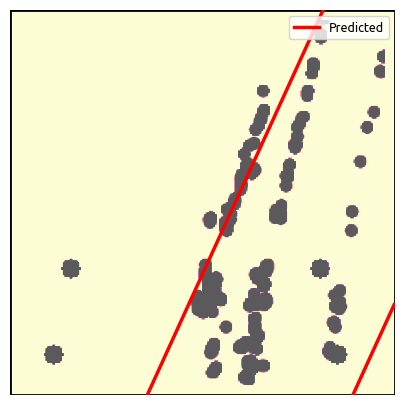

In [14]:
fig, ax = plt.subplots(figsize=(8, 5), frameon=True)

linewidth = 2.5

ax.plot(x, y1p, color='red', label='Predicted', linewidth=linewidth)
ax.plot(x, y2p, color='red', linewidth=linewidth)

# Customize the title
# title_font = {'family': 'Ubuntu', 'color': 'black', 'weight': 'bold', 'size': 18}
# plt.title('Inference Results', fontdict=title_font)

# Add a white rectangle to create a border
border_style = dict(facecolor='none', edgecolor='black', linewidth=2)
ax.add_patch(plt.Rectangle((0, 0), 1, 1, **border_style, transform=ax.transAxes))

# legend
plt.legend(loc='upper right', prop={'size': 9, 'family': 'Ubuntu'})

# show the image
im = ax.imshow(image, cmap='magma', norm=PowerNorm(gamma=16), alpha=0.65)
ax.axis('off')

plt.show()